# Heart Disease Prediction Model

This notebook offers insight into heart disease diagnosis. It contains a machine-learning model built with an anonymized data set. The primary model used here is a Support Vector Machine (SVM) with a linear kernel. Users can explore the data visualizations or even get a prediction upon entering in the required inputs (see section 8).

## Table of Contents

1. [Introduction and Setup](#introduction-and-setup)
2. [Data Visualization](#data-visualization)
3. [Model Training](#model-training)
4. [Model Evaluation](#model-evaluation)
5. [Feature Importance](#feature-importance)
6. [Confusion Matrix Visualization](#confusion-matrix-visualization)
7. [Correlation Matrix Visualization](#correlation-matrix)
8. [Predicting Heart Disease](#predicting-heart-disease)

## Introduction and Setup <a name="introduction"></a>

### About

This notebook was developed using an anonymized dataset from:
    https://archive.ics.uci.edu/dataset/45/heart+disease

The data exists through 14 columns, which will have abbreviated names in the cells below.

* age: Patient age
* sex: Female = 0, male = 1
* cp: Chest pain (1 = typical angina, 2 = atypical angina, 3 = non-anginal pain, 4 = asymptomatic)
* trestbps: Resting blood pressure in mm/Hg
* chol: Serum cholesterol in mg/dl
* fbs: Fasting blood sugar > 120 mg/dl (1 = true, 0 = false)
* restecg: Resting electrocardiographic results (0 = normal, 1 = ST-T wave abnormal, 2 = left ventricular hypertrophy)
* thalach: Maximum heart rate
* exang: Exercise-induced angina (1 = true, 0 = false)
* oldpeak: ST depression induced by exercise relative to rest
* slope: Slope of peak exercise ST segment (1 = upslope, 2 = false, 3 = downslope)
* ca: Count of major vessesl (0-3) colored by fluoroscopy
* thal: Thalassemia (3 = normal, 6 = fixed defect, 7 = reversible defect)
* num: **TARGET COLUMN** presence of heart disease (0 = false, 1 = true)

### Industry Specific Security Features

The data in this notebook has been completely anonymized. This prediction model is not a substitute for a trained medical professional. This notebook's functions work with non-identifying information. While this notebook contains no patient data, it is essential patient data must always be handled in compliance with local laws and regulations. For American users, this includes but is not limited to HIPAA and the HITECH Act.

### Monitoring and Maintenance

The repo for this notebook is freely available at https://github.com/ZenSpace55/c964. Please feel free to clone. For monitoring, if any issues are discovered feel free to create an issue. Note, this notebook can be hosted locally as a Jupyter Notebook. For maintenance, please pull the latest version to receive any updates to this file.

   
### Setup

The cell below contains our imports, followed by a few steps to clean and format our data. Immediately after the cell, the first five rows of the dataset are printed for information purposes.

In [17]:
# Import necessary libraries
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

# Load the dataset
column_names = ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 
                'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'num']
data = pd.read_csv('heart-disease-data.csv', header=None, names=column_names)

# Drop any rows with incomplete data ('?') and simplify our target column to a binary value
data.replace('?', np.nan, inplace=True)
data.dropna(inplace=True)
data['num'] = data['num'].apply(lambda x: 1 if x != 0 else 0)

# Display the first few rows of the cleaned dataset
pd.set_option('display.width',1000)
print(data.head())

    age  sex   cp  trestbps   chol  fbs  restecg  thalach  exang  oldpeak  slope   ca thal  num
0  63.0  1.0  1.0     145.0  233.0  1.0      2.0    150.0    0.0      2.3    3.0  0.0  6.0    0
1  67.0  1.0  4.0     160.0  286.0  0.0      2.0    108.0    1.0      1.5    2.0  3.0  3.0    1
2  67.0  1.0  4.0     120.0  229.0  0.0      2.0    129.0    1.0      2.6    2.0  2.0  7.0    1
3  37.0  1.0  3.0     130.0  250.0  0.0      0.0    187.0    0.0      3.5    3.0  0.0  3.0    0
4  41.0  0.0  2.0     130.0  204.0  0.0      2.0    172.0    0.0      1.4    1.0  0.0  3.0    0


## Data Visualization <a name="data-visualization"></a>

Below are a series of histograms to give a more thorough look into our dataset. Each attribute is charted out on a graph.

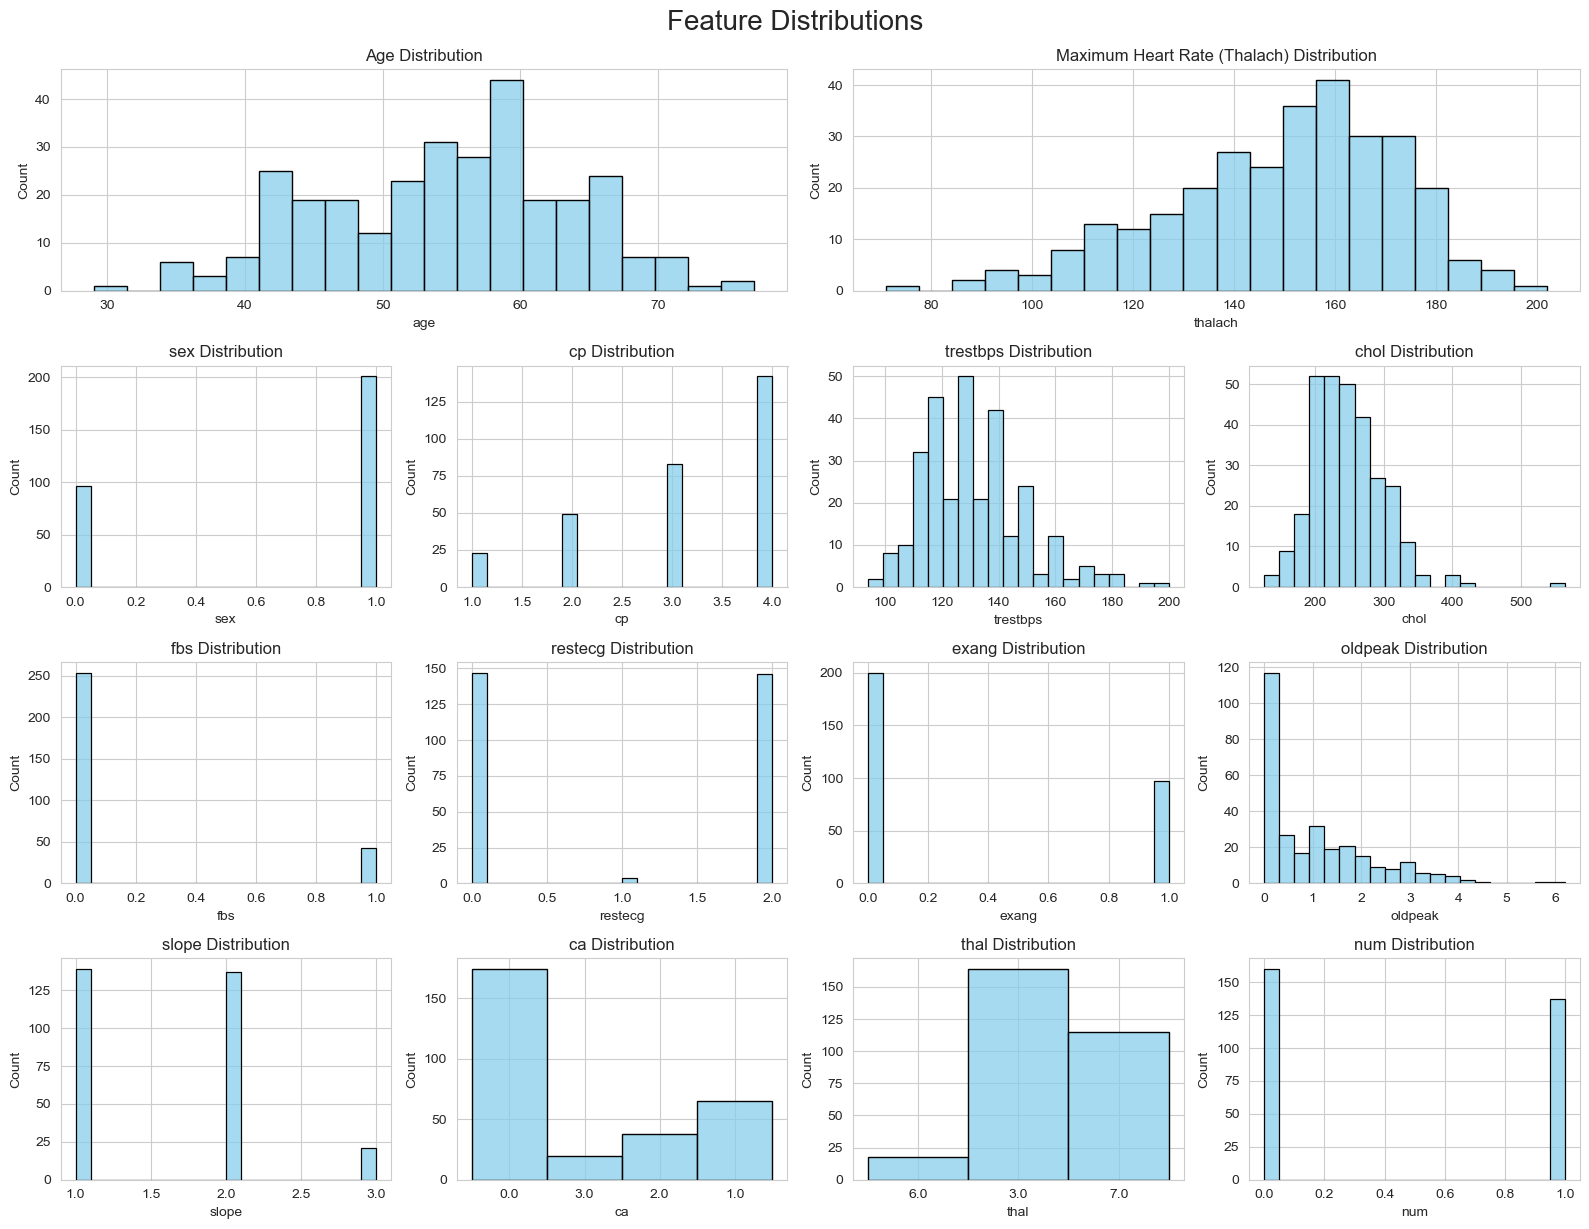

In [19]:
# Since we have 14 histograms, we must get more creative with the layout
sns.set_style("whitegrid")
fig = plt.figure(figsize=(16, 12))
gs = GridSpec(4, 4, figure=fig)

# Enlarging 'age' and 'thalach' histograms
ax1 = fig.add_subplot(gs[0, :2])  # 'age' will take the top row, first 2 columns
ax2 = fig.add_subplot(gs[0, 2:])  # 'thalach' will take the top row, last 2 columns

# Plot the enlarged histograms
sns.histplot(data['age'], bins=20, color='skyblue', edgecolor='black', ax=ax1)
ax1.set_title('Age Distribution')

sns.histplot(data['thalach'], bins=20, color='skyblue', edgecolor='black', ax=ax2)
ax2.set_title('Maximum Heart Rate (Thalach) Distribution')
axes = [fig.add_subplot(gs[i, j]) for i in range(1, 4) for j in range(4)]

# Exclude 'age' and 'thalach' from this loop since they're already plotted
columns_to_plot = [col for col in data.columns if col not in ['age', 'thalach']]

for ax, col in zip(axes, columns_to_plot):
    sns.histplot(data[col], bins=20, color='skyblue', edgecolor='black', ax=ax)
    ax.set_title(f'{col} Distribution')

# Remove any extra subplots
for ax in axes[len(columns_to_plot):]:
    fig.delaxes(ax)

plt.tight_layout()
plt.suptitle('Feature Distributions', fontsize=20, y=1.02)
plt.show()

## Model Training <a name="model-training"></a>

In this section, we prepare the dataset by splitting it into training and testing sets, scale the features, and train a Support Vector Machine (SVM) model. This model will help us predict the presence of heart disease based on the provided features.

In [21]:
# 'num' is our target column
X = data.iloc[:, 0:13]
y = data['num']

# Split and scale the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train the SVM model
svm_model = SVC(kernel='linear', max_iter=10000)
svm_model.fit(X_train_scaled, y_train)

SVC(kernel='linear', max_iter=10000)

## Model Evaluation <a name="model-evaluation"></a>

After training the model, we evaluate our model's accuracy. Two functions are used from scikit-learn, an accuracy score and a more detailed classification report. This step helps us understand how well our model is performing on the test data.

In [23]:
# Evaluate the SVM model
y_pred_svm = svm_model.predict(X_test_scaled)
accuracy_svm = accuracy_score(y_test, y_pred_svm)
class_report_svm = classification_report(y_test, y_pred_svm)

# Output results for SVM
print("SVM Model Results")
print(f"Test Accuracy: {accuracy_svm:.2f}")
print("Classification Report:\n", class_report_svm)

SVM Model Results
Test Accuracy: 0.88
Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.92      0.90        36
           1       0.87      0.83      0.85        24

    accuracy                           0.88        60
   macro avg       0.88      0.88      0.88        60
weighted avg       0.88      0.88      0.88        60



## Feature Importance <a name="feature-importance"></a>

Next, we analyze the importance of each input attribute from the trained SVM model. This allows us to identify the most impactful features when diagnosing heart disease.

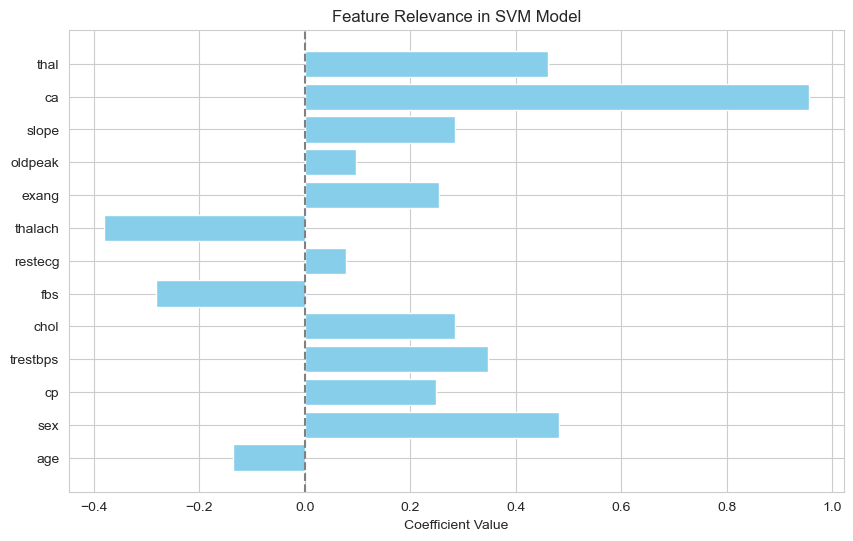

In [25]:
# Extract feature coefficient names from our column headers
feature_names = X.columns
coefficients = svm_model.coef_.flatten()

# Create a bar plot of feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_names, coefficients, color='skyblue')
plt.xlabel('Coefficient Value')
plt.title('Feature Relevance in SVM Model')
plt.axvline(0, color='gray', linestyle='--')
plt.show()

## Confusion Matrix Visualization <a name="confusion-matrix-visualization"></a>

A confusion matrix will give insight into our model's performance as far as false positives and false negatives go. A 4x4 chart is an intuitive way to monitor this, with predictions on the x-axis.

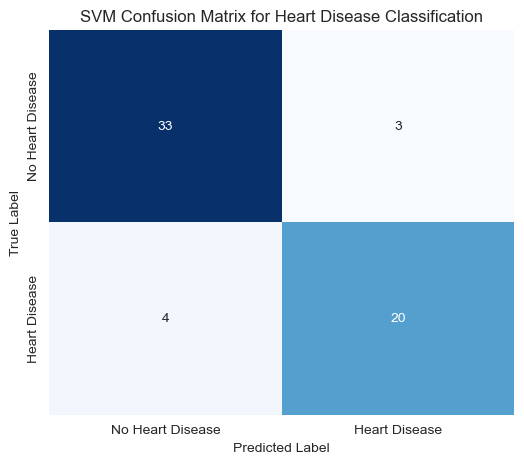

In [27]:
# Plot the confusion matrix as a heatmap
conf_matrix_svm = confusion_matrix(y_test, y_pred_svm)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix_svm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['No Heart Disease', 'Heart Disease'], yticklabels=['No Heart Disease', 'Heart Disease'])
plt.title('SVM Confusion Matrix for Heart Disease Classification')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

## Correlation Matrix <a name="correlation-matrix"></a>

To understand how our attributes relate to each other, we can examine the correlation matrix below. This analysis is part of the notebook's descriptive methods.

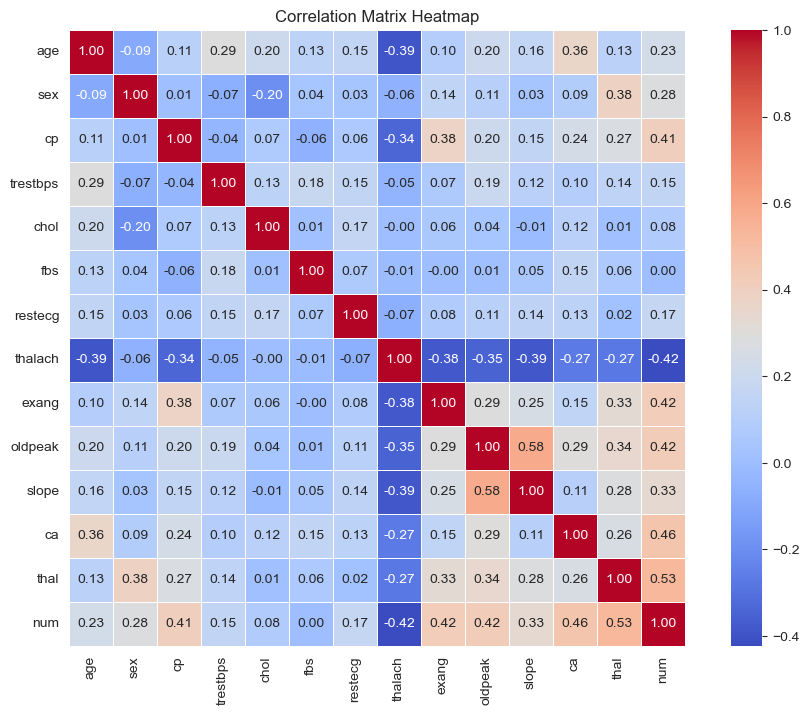

In [29]:
# Calculate the correlation matrix
corr_matrix = data.corr()

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", cbar=True,
            square=True, linewidths=0.5, annot_kws={"size": 10})

plt.title('Correlation Matrix Heatmap')
plt.show()

## Predicting Heart Disease <a name="predicting-heart-disease"></a>

Finally, we provide an interactive function that allows users to input patient data and receive a prediction on the presence of heart disease. Users must enter the correct attributes to the input box below. Please see the comments in the Python block for a few examples of correctly structured inputs.

In [31]:
def predict_heart_disease():
    # Prompt the user for patient information
    patient = input("Enter patient data (age, sex, cp, trestbps, chol, fbs, restecg, thalach, exang, oldpeak, slope, ca, thal):\n")
    
    # Split input string into a list of values and validate
    try:
        patient_values = list(map(float, patient.split()))
    except ValueError:
        print("Invalid input. Please enter numeric values separated by spaces.")
        return
    if len(patient_values) != 13:
        print(f"Expected 13 values, but received {len(patient_values)}. Please try again.")
        return

    # Create a DataFrame with the correct feature names
    patient_df = pd.DataFrame([patient_values], columns=X.columns)
    patient_scaled = scaler.transform(patient_df)

    # Predict using our model and output the result
    prediction = svm_model.predict(patient_scaled)
    result = "Heart Disease Present" if prediction[0] == 1 else "No Heart Disease"
    print(f"Prediction: {result}")

# Call the above function for a prediction
predict_heart_disease()

#SAMPLE INPUTS
#55 0 2 130 250 0 1 140 0 1.0 2 0 3
#63 1 4 145 233 1 2 150 0 2.3 3 0 6
#70 1 4 160 286 0 2 108 1 1.5 2 3 7

Enter patient data (age, sex, cp, trestbps, chol, fbs, restecg, thalach, exang, oldpeak, slope, ca, thal):
 70 1 4 160 286 0 2 108 1 1.5 2 3 7


Prediction: Heart Disease Present
